# PCNA Glimpse generation

This notebook is designed to generate large amount of cropped images of cells with the PCNA-irfp marker for a cluster analysis

In [17]:
import btrack
import matplotlib.pyplot as plt
import os, glob
from skimage.io import imread, imsave, imshow
from tqdm import tqdm
import numpy as np
from pathlib import Path
import shutil
from natsort import natsorted
from PIL import Image
import warnings
warnings.filterwarnings('ignore') ###bc imsave throws up low contrast warnings

# Set params

In [56]:
log = []

expt_root_folder = '/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi'

expt = 'MK0000'

channels = ['003'] ### bf 000 gfp 001 rfp 002 irfp 003

focal_time_range = (0, 800) ### this particular expt stays in focus in this time range

glimpse_size = (64,64)

pos_list = natsorted([pos for pos in os.listdir(os.path.join(expt_root_folder, expt)) if 'Pos' in pos])

In [ ]:
for pos in tqdm(pos_list):
    try:
        print('starting', pos)
        tracks_path_list = glob.glob(os.path.join(expt_root_folder,'{}/{}/gfp*.h5'.format(expt,pos)))
        if len(tracks_path_list) == 1:
            tracks_path = tracks_path_list[0]
        else:
            continue
        with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_1") as hdf:
            wt_tracks = hdf.tracks

        message = str(pos) + 'tracking file loaded'
        log.append(message)
        print(message)

        ### filter tracks that should contain a full cell cycle in (1 timepoint/frame = 4min, cc time approx 200 frames based on quick look)
        long_tracks = [track for track in wt_tracks if len(track) > 200]

        ### filter tracks that spend a lot of time out of focus
        tracks = [track for track in long_tracks if track.t[-1] < focal_time_range[1]]

        ### show number of filtered tracks
        message = str(pos)+'number of glimpses to be generated:'+str(len(tracks))
        log.append(message)
        print(message)

        ### find images and set output
        image_folder = os.path.join(expt_root_folder,expt, pos, pos+'_stacks')
        output_dir = '/home/nathan/data/kraken/pcna/glimpses/{}/{}'.format(expt, pos)

        for channel in channels:
            ### load images
            print('Loading image channel', channel)
            images = imread(os.path.join(image_folder, 'channel{}.tif'.format(channel)))
            print('Image loaded')
            message = str(pos) + 'image loaded'
            log.append(message)

            ### create output directory
            output_ch_dir = os.path.join(output_dir, 'channel'+channel)
            Path(output_ch_dir).mkdir(parents=True, exist_ok=True)

            for cell in tqdm(tracks):
                try:
                    message = 'attempting' + str(pos) + 'cell ID' + str(cell.ID)
                    log.append(message)
                    print(message)

                    ### get length of track/glimpse 
                    length = range(cell.t[0], cell.t[-1])
                    ### get the xy coords of track/glimpse 
                    y, x = cell.x, cell.y #### WHY IS THE COORDINATES TRANSPOSED???? 

                    ### iterate over all frames cropping
                    for j, i in enumerate(length): ## need to have something that solves skipped frames # not including the last frame bc list index out of range ie there is one more i than there
                        ### obtain correct frame
                        image = images[i]
                        ### get glimpse dimensions 
                        size = int(glimpse_size[0])
                        ### obtain coordinates of bounding box of glimpse (centered on cell)
                        x1, x2, y1, y2 = x[j], x[j]+size, y[j], y[j]+size #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
                        ### pad image incase cell goes off FOV
                        image = np.pad(image, int(size/2), 'constant', constant_values = 0) 
                        ## glimpse creation by cropping original image
                        glimpse = image[int(x1): int(x2), int(y1): int(y2)]
                        ### fraction of track this frame is at
                        age = round(j/len(cell),3)
                        fn = str(pos)+'_cell_ID_' + str(cell.ID) + '_channel' + channel + '_t{}_age{}.tif'.format(i, age)
                        ### glimpse output
                        imsave(os.path.join(output_ch_dir, fn), glimpse) 

                    message = str(pos)+'cell ID'+ str(cell.ID) + 'glimpse saved'
                    print(message)

                except:
                    print(cell.ID, 'failed to produce glimpse')
    except:
        message = 'something went big wrong on' +str(pos)

  0%|          | 0/24 [00:00<?, ?it/s][INFO][2021/05/27 06:56:52 PM] Opening HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_21_05_29_08_PM.h5...
[INFO][2021/05/27 06:56:52 PM] Loading tracks/obj_type_1


starting Pos0


[INFO][2021/05/27 06:56:52 PM] Loading objects/obj_type_1 (563356, 5) (563356 filtered: None)
[INFO][2021/05/27 06:56:59 PM] Closing HDF file: /run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/MK0000/Pos0/gfp_tracks_2021_05_21_05_29_08_PM.h5


Pos0tracking file loaded
Pos0number of glimpses to be generated:275
Loading image channel 003


# organising output into one big folder indiscriminate of expt params

In [9]:
### collating files
files = []
glimpse_parent_folder = '/home/nathan/data/kraken/pcna/glimpses/MK0000'
pos_list = [pos for pos in os.listdir(glimpse_parent_folder) if 'Pos' in pos]
for pos in pos_list:
    pos_folder = os.path.join(glimpse_parent_folder, pos)
    channel_dirs = os.listdir(pos_folder)
    for channel in channel_dirs:
        channel_folder = os.path.join(pos_folder, channel)
        files.extend(glob.glob(os.path.join(channel_folder, '*.tif')))
    

In [16]:
### copying files
output_dir = os.path.join(glimpse_parent_folder, 'all')
Path(output_dir).mkdir(parents=True, exist_ok=True)
for i in tqdm(files):
    dest = os.path.join(output_dir, os.path.basename(i))
    shutil.copyfile(i, dest)

100%|██████████| 174706/174706 [25:10<00:00, 115.67it/s] 


# cropping files down to 64px2

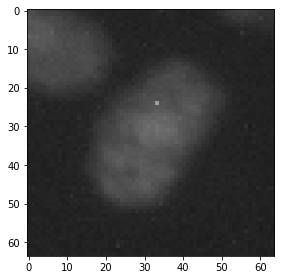

In [37]:
final_shape = (64,64)
all_patches_dir = os.path.join(glimpse_parent_folder, 'all')
files = [fn for fn in os.listdir(all_patches_dir) if '.tif' in fn]

for image_fn in ['Pos0_cell_ID_3183_channel003_t374_age0.708.tif']:# files:
    image_path = os.path.join(all_patches_dir, image_fn)
    image = imread(image_path)
    shape = image.shape
    crop_amount = (shape[0]-final_shape[0])/2
    x1, y1, x2, y2 = int(crop_amount), int(crop_amount), int(crop_amount+final_shape[0]) , int(crop_amount+final_shape[0])
    image = image[x1: x2, y1:y2 ]
    imshow(image)
    break

In [42]:
filtered_files = natsorted([fn for fn in files if 'Pos0_cell_ID_3183' in fn])

In [43]:
filtered_files

['Pos0_cell_ID_3183_channel003_t308_age0.583.tif',
 'Pos0_cell_ID_3183_channel003_t309_age0.585.tif',
 'Pos0_cell_ID_3183_channel003_t310_age0.587.tif',
 'Pos0_cell_ID_3183_channel003_t311_age0.589.tif',
 'Pos0_cell_ID_3183_channel003_t312_age0.591.tif',
 'Pos0_cell_ID_3183_channel003_t313_age0.593.tif',
 'Pos0_cell_ID_3183_channel003_t314_age0.595.tif',
 'Pos0_cell_ID_3183_channel003_t315_age0.597.tif',
 'Pos0_cell_ID_3183_channel003_t316_age0.598.tif',
 'Pos0_cell_ID_3183_channel003_t317_age0.6.tif',
 'Pos0_cell_ID_3183_channel003_t318_age0.602.tif',
 'Pos0_cell_ID_3183_channel003_t319_age0.604.tif',
 'Pos0_cell_ID_3183_channel003_t320_age0.606.tif',
 'Pos0_cell_ID_3183_channel003_t321_age0.608.tif',
 'Pos0_cell_ID_3183_channel003_t322_age0.61.tif',
 'Pos0_cell_ID_3183_channel003_t323_age0.612.tif',
 'Pos0_cell_ID_3183_channel003_t324_age0.614.tif',
 'Pos0_cell_ID_3183_channel003_t325_age0.616.tif',
 'Pos0_cell_ID_3183_channel003_t326_age0.617.tif',
 'Pos0_cell_ID_3183_channel003_t32